# QFT on QC
This notebook demonstrates how to use the Quantum Field Theory (QFT) on a quantum computer using numpy and Qiskit.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Stadium Billiard: Classical Motion

The stadium consists of a rectangle of half-length $a$ and vertical extent $\pm b$, capped on both sides by half-ellipses of semi-axes $(r_x, r_y)$. The boundary of an ellipse satisfies:

$$\frac{x^2}{r_x^2} + \frac{y^2}{r_y^2} = 1$$

## Part A: Classical Motion (Newtonian Dynamics)

**Tasks:**
1. Numerically integrate Newton's equations for a free particle in the elliptic stadium with perfectly reflecting boundaries
2. Plot trajectories for:
    - Short times $T$ (a few bounces)
    - Longer times $T$ (where the trajectory begins to cover the stadium)
3. Discuss how generic initial conditions can lead to ergodic-like coverage of the billiard

**Sanity Checks:**
1. Verify reflections: confirm the law of reflection using boundary normals at bounce points
2. Test energy conservation
3. Show sensitivity to initial conditions as a diagnostic of chaos


Progress: 100%



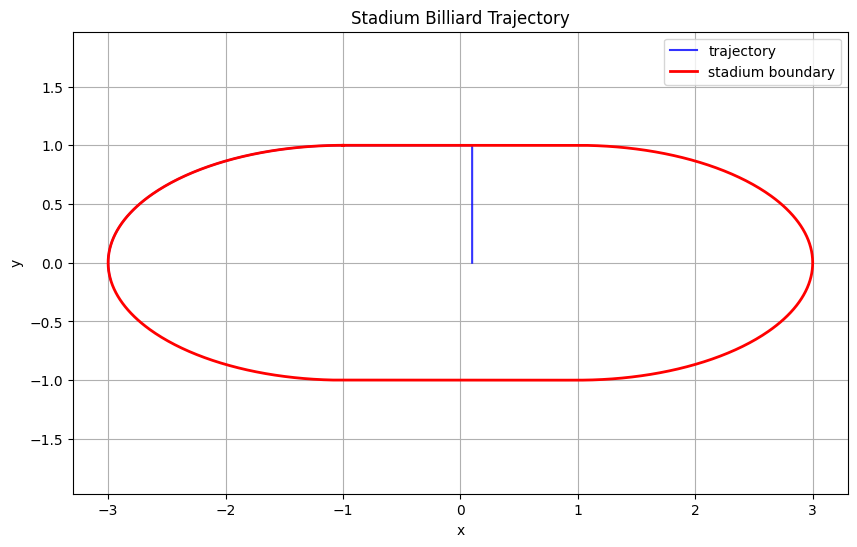

In [146]:
# Stadium billiard parameters
a = 1.0  # half-length of rectangle
b = 1.0  # half-height of rectangle
rx = 2.0  # x semi-axis of end caps
ry = b    # y semi-axis of end caps (same as rectangle height)


def is_in_stadium(x, y):
    """Check if point (x,y) is inside the stadium."""
    if abs(x) <= a:  # Rectangle part
        return abs(y) <= b
    else:  # Elliptical caps
        x_shifted = abs(x) - a
        return (x_shifted/rx)**2 + (y/ry)**2 <= 1


def get_normal(x, y):
    """Return outward normal at a boundary point (x,y) for the stadium.
    For the elliptical caps centered at x=+/-a, the unnormalized normal is (x'/rx**2, y/ry**2)
    where x' = x - sign(x)*a. For rectangle edges the normal is axis-aligned.
    """
    sx = np.sign(x) if x != 0 else 1
    # Top/bottom of rectangle (horizontal edges)
    if abs(x) <= a and abs(y) >= b - 1e-12:
        return np.array([0.0, np.sign(y)])
    # Elliptical caps (x outside +/-a)
    if abs(x) > a - 1e-12:
        x_shifted = x - sx * a
        return np.array([x_shifted/(rx**2), y/(ry**2)])
    # Side walls (vertical edges)
    if abs(y) <= b and abs(x) >= a - 1e-12:
        return np.array([np.sign(x), 0.0])
    # Fallback
    return np.array([np.sign(x), np.sign(y)])


def reflect_velocity(v, normal):
    """Reflect velocity vector v about normal n, with noise suppression for axis-aligned walls.
    Returns a numpy array with tiny components zeroed to avoid drift.
    """
    n = normal / np.linalg.norm(normal)
    # if normal is nearly axis aligned, snap it exactly to axis to avoid drift
    if abs(n[0]) < 1e-12:
        n[0] = 0.0
    if abs(n[1]) < 1e-12:
        n[1] = 0.0
    v_ref = v - 2 * np.dot(v, n) * n
    # kill tiny numerical components
    v_ref[np.abs(v_ref) < 1e-12] = 0.0
    return v_ref


def simulate_trajectory(x0, y0, vx0, vy0, dt=0.01, steps=100000, max_bounces=None, show_progress=False):
    """Simulate particle trajectory with bisection collision detection.
    max_bounces: if set, stop after that many reflections (None = unlimited).
    show_progress: if True, prints percentage complete (every ~1%).
    """
    x_list, y_list = [x0], [y0]
    vx, vy = float(vx0), float(vy0)
    bounce_count = 0

    # progress bookkeeping
    if show_progress:
        progress_every = max(1, steps // 100)
        last_pct = -1

    for i in range(steps):
        x_prev, y_prev = x_list[-1], y_list[-1]
        x_new = x_prev + vx * dt
        y_new = y_prev + vy * dt

        if not is_in_stadium(x_new, y_new):
            # bisection to find collision point between inside (t=0) and outside (t=1)
            t_lo, t_hi = 0.0, 1.0
            def interp(t):
                return x_prev + (x_new - x_prev) * t, y_prev + (y_new - y_prev) * t
            for _ in range(60):
                tm = 0.5 * (t_lo + t_hi)
                xm, ym = interp(tm)
                if is_in_stadium(xm, ym):
                    t_lo = tm
                else:
                    t_hi = tm
                if t_hi - t_lo < 1e-9:
                    break
            t_coll = 0.5 * (t_lo + t_hi)
            x_coll, y_coll = interp(t_coll)

            normal = get_normal(x_coll, y_coll)
            v_ref = reflect_velocity(np.array([vx, vy]), normal)
            vx, vy = float(v_ref[0]), float(v_ref[1])

            bounce_count += 1
            if max_bounces is not None and bounce_count > max_bounces:
                # append collision point and stop
                x_list.append(x_coll); y_list.append(y_coll)
                break

            # advance remaining fraction of the step after collision
            remaining = (1.0 - t_coll)
            x_new = x_coll + vx * dt * remaining
            y_new = y_coll + vy * dt * remaining

            # clamp if still outside due to tiny rounding
            if not is_in_stadium(x_new, y_new):
                x_new, y_new = x_coll, y_coll

        x_list.append(x_new)
        y_list.append(y_new)

        # safety: if the particle goes extremely far, stop
        if abs(x_new) > 10*a or abs(y_new) > 10*b:
            break

        # progress printing
        if show_progress and (i % progress_every == 0 or i == steps-1):
            pct = int((i+1) * 100 / steps)
            if pct != last_pct:
                print(f"Progress: {pct}%", end="\r", flush=True)
                last_pct = pct

    if show_progress:
        print('', flush=True)  # finish the line

    return np.array(x_list), np.array(y_list)


def stadium_boundary(a, b, rx, ry, n=400):
    """Return closed boundary coordinates for the stadium."""
    ne = max(2, n//8)
    nc = max(2, (n - 2*ne)//2)
    xt = np.linspace(-a, a, ne)
    yt = np.full_like(xt, b)
    tr = np.linspace(np.pi/2, -np.pi/2, nc)
    xr = a + rx * np.cos(tr)
    yr = ry * np.sin(tr)
    xb = np.linspace(a, -a, ne)
    yb = np.full_like(xb, -b)
    tl = np.linspace(-np.pi/2, np.pi/2, nc)
    xl = -a - rx * np.cos(tl)
    yl = ry * np.sin(tl)
    X = np.concatenate([xt, xr, xb, xl, xt[:1]])
    Y = np.concatenate([yt, yr, yb, yl, yt[:1]])
    return X, Y


# Example trajectory: vertical motion at x=0.1 should remain vertical without drift
# set show_progress=True to see percentage completion
x, y = simulate_trajectory(0.1, 0, 0, 1, dt=0.01, steps=399999, show_progress=True)

# Plot the trajectory and the stadium boundary
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'b-', alpha=0.8, label='trajectory')
Xb, Yb = stadium_boundary(a, b, rx, ry, n=800)
plt.plot(Xb, Yb, 'r-', linewidth=2, label='stadium boundary', zorder=5)
plt.axis('equal')
plt.grid(True)
plt.title('Stadium Billiard Trajectory')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()